C:\Users\amit garg\Anaconda3\envs\firstenv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LOGISTIC REGRESSION
Confusion Matrix from Logistic Regression
[[1889   11]
 [  47  201]]
Accuracy from Logistic Regression = 0.972998137802607
Recall from Logistic Regression = 0.8104838709677419
Precision from Logistic Regression = 0.9481132075471698
F1 score from Logistic Regression = 0.8739130434782608
SVM CLASSIFIER
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   43.2s finished


Best parameters set found on development set:
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Confusion Matrix from SVM Classifier
[[1893    7]
 [  66  182]]
Accuracy from SVM Classifier = 0.9660148975791434
Recall from SVM Classifier = 0.7338709677419355
Precision from SVM Classifier = 0.9629629629629629
F1 score from SVM Classifier = 0.8329519450800915


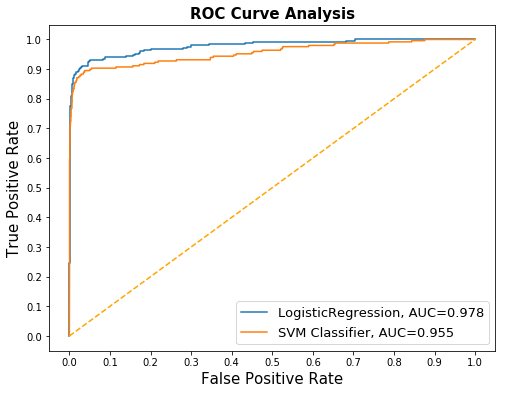

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# importing data
data = pd.read_csv("train.csv")

# customer_active_segment and X1 are categorical variables, and also contain NaN values
# For each of these categorical variables, each category is used to make dummy variables,
# with all dummy variables 0 indicating NaN values
for e in set(data['customer_active_segment']):
    if not pd.isna(e):
        data[str('customer_active_segment') + str(e)] = (data['customer_active_segment'] == e).astype(int)

for e in set(data['X1']):
    if not pd.isna(e):
        data[str('X1') + str(e)] = (data['X1'] == e).astype(int)

# Following 4 continuous variables contain NaN values: customer_product_search_score, customer_stay_score
# customer_product_variation_score, and customer_order_score
# For each of these continuous variables, additional dummy variable is created indicating if corresponding cell of the
# continuous variable is NaN or not
data['customer_product_search_scoreNA'] = 0
data['customer_product_search_scoreNA'] = [1 if pd.isna(x) else 0 for x in data['customer_product_search_score']]

data['customer_stay_scoreNA'] = 0
data['customer_stay_scoreNA'] = [1 if pd.isna(x) else 0 for x in data['customer_stay_score']]

data['customer_product_variation_scoreNA'] = 0
data['customer_product_variation_scoreNA'] = [1 if pd.isna(x) else 0 for x in data['customer_product_variation_score']]

data['customer_order_scoreNA'] = 0
data['customer_order_scoreNA'] = [1 if pd.isna(x) else 0 for x in data['customer_order_score']]

# Since all NaN values are taken care of with dummy variables, these NaN values are not replaced with 0
data = data.fillna(0)

# Separating target and explanatory variables and dropping categorical and ID variables
x = data.drop(['customer_id', 'customer_active_segment', 'X1', 'customer_category'], axis=1)
y = data['customer_category']

# Splitting data for training and validation
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#Dataframe for AUC ROC curves
result_table = pd.DataFrame(columns=['classifiers', 'fpr', 'tpr', 'auc'])

# Fitting logistic regression model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[::, 1]

# confusion matrix and other metrics from Logistic Regression
print('LOGISTIC REGRESSION')
print('Confusion Matrix from Logistic Regression')
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
acc = (tp + tn) / (tp + tn + fp + fn)
f1 = 2*tp / (2*tp + fn + fp)
print('Accuracy from Logistic Regression = {}'.format(acc))
print('Recall from Logistic Regression = {}'.format(recall))
print('Precision from Logistic Regression = {}'.format(precision))
print('F1 score from Logistic Regression = {}'.format(f1))
fpr, tpr, _ = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
result_table = result_table.append({'classifiers': clf.__class__.__name__,
                                    'fpr': fpr,
                                    'tpr': tpr,
                                    'auc': auc}, ignore_index=True)

# SVM Classifier
# Setting parameters for grid search and cross validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10]}]

# Fitting grid search cross validation
print('SVM CLASSIFIER')
mdl = GridSearchCV(SVC(probability=True), tuned_parameters, verbose=1)
mdl.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(mdl.best_params_)
y_pred = mdl.predict(X_test)
y_prob = mdl.predict_proba(X_test)[::, 1]

# confusion matrix and other metrics from SVM Classifier
print('Confusion Matrix from SVM Classifier')
print(confusion_matrix(y_test, y_pred))
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
acc = (tp + tn) / (tp + tn + fp + fn)
f1 = 2*tp / (2*tp + fn + fp)
print('Accuracy from SVM Classifier = {}'.format(acc))
print('Recall from SVM Classifier = {}'.format(recall))
print('Precision from SVM Classifier = {}'.format(precision))
print('F1 score from SVM Classifier = {}'.format(f1))
fpr, tpr, _ = roc_curve(y_test,  y_prob)
auc = roc_auc_score(y_test, y_prob)
result_table = result_table.append({'classifiers': mdl.__class__.__name__,
                                    'fpr': fpr,
                                    'tpr': tpr,
                                    'auc': auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table['classifiers'] = ['LogisticRegression', 'SVM Classifier']
result_table.set_index('classifiers', inplace=True)

# ROC curves analysis
fig = plt.figure(figsize=(8, 6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.plot([0, 1], [0, 1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size': 13}, loc='lower right')
plt.savefig("ROCcurves.pdf")
plt.show()